# **Campañas publicitarias en redes sociales - Modelos de Regresión**

### **Trabajaremos con el archivo "dataset_Facebook.csv" que encuentras en la siguiente liga:**

https://archive.ics.uci.edu/dataset/368/facebook+metrics


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

from sklearn import metrics
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import learning_curve

from sklearn.model_selection import RandomizedSearchCV

## **Ejercicio 1**


Las curvas de aprendizaje, son una representación gráfica que muestran alguna clase de experiencia en el eje x y su correspondiente desempeño en el eje y.
A medida que podemos ir conociendo como cambia la experiencia, (puede ser algún hiperparámetro, proporción del conjunto de entrenamiento, etc.) nos daremos cuenta cómo esto afecta en el desempeño de nuestro modelo  tamtp en el entrenamiento, como en la prueba.

El diagnóstico del sub o sobre entrenamiento, nos lo irá dando la interpretacion del gráfico en cada modelo. Y para monitorearlo, el uso de estas técnica nos podrá dar una muy buena idea de los accuracys que podríamos esperar y del ruido inherente en nuestro problema.

## **Ejercicio 2**

In [2]:
# Cargamos los datos:

data = pd.read_csv('dataset_Facebook.csv', sep=';', header='infer')

# Separamos los datos de entrada y la variable de salida:
X = data.iloc[:,0:7]   # Las primeras 7 columnas son las variables de entrada.
y = data[['Lifetime Post Consumers']]   # Hay 12 variables de salida, pero solo trabajaremos con la
                                        # que se consideró la más importante en el artículo de reporte.

# Renombramos los niveles de "Type", para tener solo valores numéricos en el DataFrame:
X['Type'] = X['Type'].map({'Photo':1, 'Status':2, 'Link':3, 'Video':4})

# Particionamos en Train, Validation y Test en 60-20-20:
Xtrain, Xtv, ytrain, ytv = train_test_split(X, y, train_size=0.6, shuffle=True, random_state=5)
Xval, Xtest, yval, ytest = train_test_split(Xtv, ytv, test_size=0.5, shuffle=True, random_state=7)


print('Train:', Xtrain.shape, ytrain.shape)
print('Val:', Xval.shape, yval.shape)
print('Test:', Xtest.shape, ytest.shape)

Train: (300, 7) (300, 1)
Val: (100, 7) (100, 1)
Test: (100, 7) (100, 1)


In [3]:
Xtrain.head() # Nuestros datos de entrada

,Page total likes,Type,Category,Post Month,Post Weekday,Post Hour,Paid
92,137059,1,3,11,1,3,0.0
45,138353,3,1,12,4,3,1.0
313,124940,1,3,6,7,3,1.0
46,138353,2,1,12,3,11,0.0
185,134879,1,1,9,1,10,0.0


In [4]:
Xtrain.describe().T   # veamos alguna descripción como datos numéricos

,count,mean,std,min,25%,50%,75%,max
Page total likes,300.0,123511.376667,16211.773474,81370.0,113028.00,130195.5,136393.0,139441.0
Type,300.0,1.216667,0.580959,1.0,1.00,1.0,1.0,4.0
Category,300.0,1.896667,0.849546,1.0,1.00,2.0,3.0,3.0
Post Month,300.0,7.106667,3.306316,1.0,4.00,7.0,10.0,12.0
Post Weekday,300.0,4.180000,2.015226,1.0,2.75,4.0,6.0,7.0
Post Hour,300.0,7.546667,4.348662,1.0,3.00,8.0,11.0,22.0
Paid,299.0,0.290970,0.454971,0.0,0.00,0.0,1.0,1.0


In [5]:
ytrain.describe().T   # lo mismo para la variable de salida

,count,mean,std,min,25%,50%,75%,max
Lifetime Post Consumers,300.0,827.986667,1009.102992,9.0,321.25,543.5,1008.75,11328.0


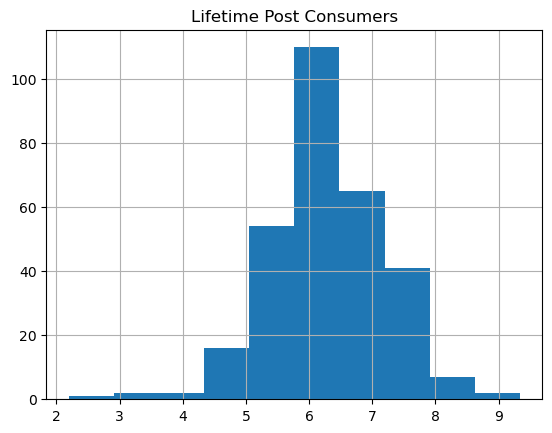

In [6]:
ytrainlog = np.log(ytrain)   # Recordemos que nuestra variable de salida en un problema
ytrainlog.hist();            # de Regresión se recomienda que esté aproximadamente
                             # acampanada, por lo que la ajustaremos con el logaritmo
                             # natural como primera aproximación.

In [7]:
# y procedemos de la misma manera con Val y test:
yvallog = np.log(yval)
ytestlog = np.log(ytest)

In [8]:
# Apliaremos lo mínimo de transformaciones, en particular para datos perdidos:
# Como solo tenemos una numérica, la podemos dejar sin escalar:
num_pipe = Pipeline(steps = [('numImp', SimpleImputer(strategy='median')),
                             ])
num_pipe_nombres = [0]   # ['Page total likes']


# Las ordinales las identificamos como tales:
ord_pipe = Pipeline(steps =  [('OrdImp', SimpleImputer(strategy='most_frequent')),
                              ('Ordfun', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1 ))
                              ])
ord_pipe_nombres = [3,4,5]   # ['Post Month', 'Post Weekday', 'Post Hour']

# Las nominales las transformamos con One-Hot-Encoder:
nom_pipe = Pipeline(steps = [('ohe', OneHotEncoder(drop='first',
                                                   handle_unknown='ignore',
                                                   ))])
nom_pipe_nombres = [1,2,6]   # ['Type', 'Category', 'Paid']


# Conjuntamos las transformaciones que aplicaremos:
columnasTransformer = ColumnTransformer(transformers = [('numpow', num_pipe, num_pipe_nombres),
                                                        ('catOrd', ord_pipe, ord_pipe_nombres),
                                                        ('catNom', nom_pipe, nom_pipe_nombres)
                                                        ],
                                        remainder='passthrough')


# Ajustamos en Train y transformamos en Val y Test:
XtrainFit = columnasTransformer.fit(Xtrain)
XtrainT = XtrainFit.transform(Xtrain)
XvalT  =  XtrainFit.transform(Xval)
XtestT  =  XtrainFit.transform(Xtest)

In [9]:
# El valor de RMSE-Root-Mean-Square-Error, se utiliza para medir el desempeño
# mínimo que debiera obtener un modelo de regresión, es decir, este valor
# se toma usualmente como el valor del modelo subentrenado y se compara generalmente
# con el valor de la desviación estándar de la variable de salida, ya sea que la
# estés tomando de manera original o con los datos transformados.
# Veamos el valor de ambas:

print('Desv-Est y-original: %.3f' % ytrain.values.std())
print('Desv-Est y-logaritmo: %.3f' % ytrainlog.values.std())

Desv-Est y-original: 1007.420
Desv-Est y-logaritmo: 0.906


## **Ejercicio 3**


Fitting 5 folds for each of 100 candidates, totalling 500 fits


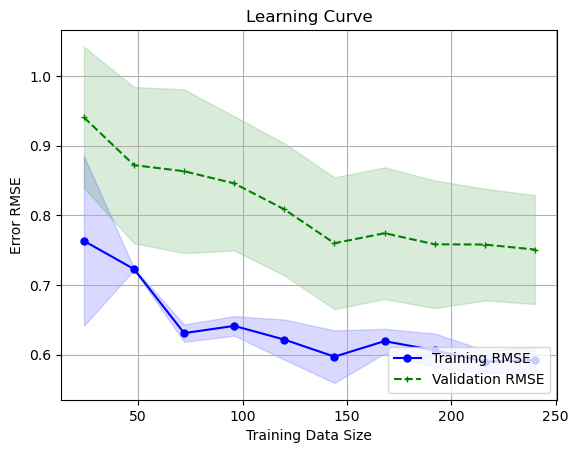

In [ ]:
#Definiendo modelo, para optimizarlo
rf_reg = RandomForestRegressor()

#Hiperparametros a optimizar
param_grid = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': [1.0, 'sqrt', 'log2'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]}

#Buscando los mejores hiperparámetros
rf_opt = RandomizedSearchCV(estimator = rf_reg, 
                               param_distributions = param_grid, 
                               n_iter = 100, 
                               cv = 5, 
                               verbose=2, 
                               random_state=42, 
                               n_jobs = -1)
rf_opt.fit(XtrainT, np.ravel(ytrainlog))

elmodelo_RF = RandomForestRegressor(**rf_opt.best_params_)


mipipe = Pipeline(steps=[('ct',columnasTransformer),('m', elmodelo_RF)])

train_sizes, train_scores, val_scores = learning_curve(estimator=mipipe,
                                                        X=XtrainT,
                                                        y=np.ravel(ytrainlog),
                                                        cv=5,
                                                        train_sizes= np.linspace(0.1, 1.0, 10),
                                                        scoring= 'neg_mean_squared_error',  # error MSE
                                                        n_jobs=-1)



# Calculamos los promedios y desviación estándar de entrenamiento para RMSE,
# como tenemos los de MSE, debemos obtener su raíz cuadrada. El negativo es porque
# sklearn nos devuelve en realidad el negativo del Error Cuadrático Medio MSE:

rmse_train_scores = np.sqrt(-train_scores)
rmse_val_scores = np.sqrt(-val_scores)

train_mean = np.mean(rmse_train_scores, axis=1)
train_std = np.std(rmse_train_scores, axis=1)
val_mean = np.mean(rmse_val_scores, axis=1)
val_std = np.std(rmse_val_scores, axis=1)


plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training RMSE')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, val_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation RMSE')
plt.fill_between(train_sizes, val_mean + val_std, val_mean - val_std, alpha=0.15, color='green')

plt.title('Learning Curve')
plt.xlabel('Training Data Size')
plt.ylabel('Error RMSE')
plt.grid()
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Una vez que verifiquemos que no está sobreentrenado o subentrenado el modelo,
# podemos calcular el RMSE del mejor ajuste con los datos de Prueba.

elmodelo_RF = RandomForestRegressor(**rf_opt.best_params_)

mipipe = Pipeline(steps=[('ct',columnasTransformer),('m', elmodelo_RF)])
mipipe.fit(Xtrain, np.ravel(ytrainlog))
yhattest_RF = mipipe.predict(Xtest)

print('Error RSME(Test) de Random Forest: %.3f' % np.sqrt(mean_squared_error(np.ravel(ytestlog), yhattest_RF)))

Error RSME(Test) de Random Forest: 0.683


## **Ejercicio 4**

### **Repite el mismo proceso del Ejercicio 3 anterior para obtener los hiperparámetros que nos lleven a casos de modelos no subentrenados o sobreentrenaos, en cada uno de los siguientes casos:**

*   **a. Extreme Gradient Boost XGBoost**
*   **b. Máquina de Vector Soporte SVM**
*   **c. Red Neuronal Perceptrón Multicapa MLP**

Fitting 5 folds for each of 100 candidates, totalling 500 fits


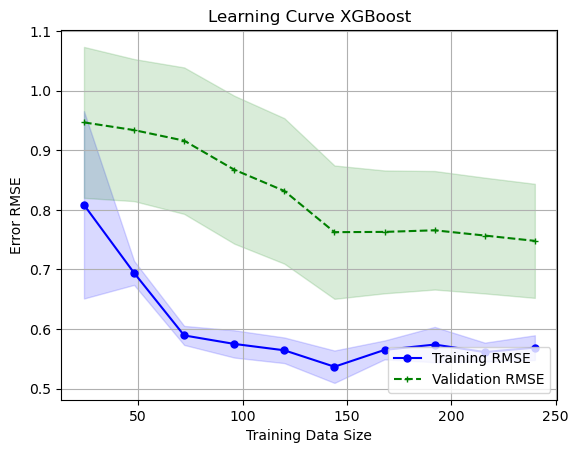

Error RSME(Test) de XGBoost: 0.716


In [ ]:
#Definiendo modelo, para optimizarlo
XGB_reg = XGBRegressor()

#Hiperparametros a optimizar
param_grid = {
    'max_depth':[int(x) for x in np.linspace(start = 3, stop = 10, num = 8)],
    'min_child_weight': [int(x) for x in np.linspace(start = 1, stop = 10, num = 10)],
    'eta':[.3, .2, .1, .05, .01, .005],
    'subsample': np.linspace(start = 0.5, stop = 1, num = 6),
    'colsample_bytree': np.linspace(start = 0.5, stop = 1, num = 6)
}

#Buscando los mejores hiperparámetros
XGB_opt = RandomizedSearchCV(estimator = XGB_reg, 
                               param_distributions = param_grid, 
                               n_iter = 100, 
                               cv = 5, 
                               verbose=2, 
                               random_state=42, 
                               n_jobs = -1)
XGB_opt.fit(XtrainT, np.ravel(ytrainlog))

elmodelo = XGBRegressor(**XGB_opt.best_params_)


mipipe = Pipeline(steps=[('ct',columnasTransformer),('m', elmodelo)])

train_sizes, train_scores, val_scores = learning_curve(estimator=mipipe,
                                                        X=XtrainT,
                                                        y=np.ravel(ytrainlog),
                                                        cv=5,
                                                        train_sizes= np.linspace(0.1, 1.0, 10),
                                                        scoring= 'neg_mean_squared_error',  # error MSE
                                                        n_jobs=-1)



# Calculamos los promedios y desviación estándar de entrenamiento para RMSE,
# como tenemos los de MSE, debemos obtener su raíz cuadrada. El negativo es porque
# sklearn nos devuelve en realidad el negativo del Error Cuadrático Medio MSE:

rmse_train_scores = np.sqrt(-train_scores)
rmse_val_scores = np.sqrt(-val_scores)

train_mean = np.mean(rmse_train_scores, axis=1)
train_std = np.std(rmse_train_scores, axis=1)
val_mean = np.mean(rmse_val_scores, axis=1)
val_std = np.std(rmse_val_scores, axis=1)


plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training RMSE')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, val_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation RMSE')
plt.fill_between(train_sizes, val_mean + val_std, val_mean - val_std, alpha=0.15, color='green')

plt.title('Learning Curve XGBoost')
plt.xlabel('Training Data Size')
plt.ylabel('Error RMSE')
plt.grid()
plt.legend(loc='lower right')
plt.show()

#Imprimiendo RMSE en conjunto de Prueba
mipipe = Pipeline(steps=[('ct',columnasTransformer),('m', elmodelo)])
mipipe.fit(Xtrain, np.ravel(ytrainlog))
yhattest_RF = mipipe.predict(Xtest)

print('Error RSME(Test) de XGBoost: %.3f' % np.sqrt(mean_squared_error(np.ravel(ytestlog), yhattest_RF)))

Fitting 3 folds for each of 50 candidates, totalling 150 fits


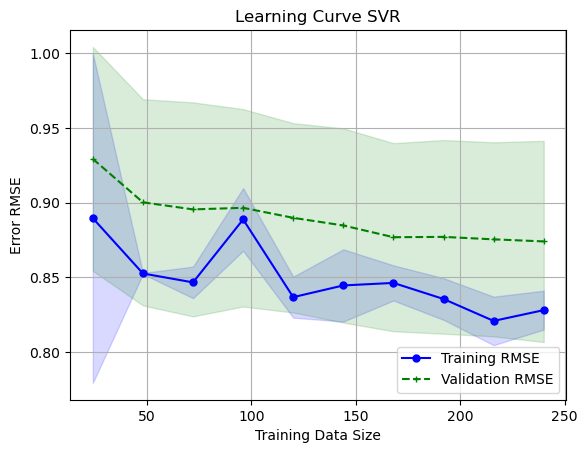

Error RSME(Test) de SVR: 0.873


In [ ]:
#Definiendo modelo, para optimizarlo
SVM_reg = SVR()

#Hiperparametros a optimizar
param_grid = {
    'C': [0.1, 1, 10, 100],  
    'gamma': [1, 0.1, 0.01, 0.001], 
    'kernel': ['rbf','sigmoid'],
    'epsilon': [0.001, 0.01, 0.1, 1, 2]
}

#Buscando los mejores hiperparámetros
SVM_opt = RandomizedSearchCV(estimator = SVM_reg, 
                               param_distributions = param_grid, 
                               n_iter = 50, 
                               cv = 3, 
                               verbose=2, 
                               random_state=42, 
                               n_jobs = -1)
SVM_opt.fit(XtrainT, np.ravel(ytrainlog))

elmodelo = SVR(**SVM_opt.best_params_)


mipipe = Pipeline(steps=[('ct',columnasTransformer),('m', elmodelo)])

train_sizes, train_scores, val_scores = learning_curve(estimator=mipipe,
                                                        X=XtrainT,
                                                        y=np.ravel(ytrainlog),
                                                        cv=5,
                                                        train_sizes= np.linspace(0.1, 1.0, 10),
                                                        scoring= 'neg_mean_squared_error',  # error MSE
                                                        n_jobs=-1)



# Calculamos los promedios y desviación estándar de entrenamiento para RMSE,
# como tenemos los de MSE, debemos obtener su raíz cuadrada. El negativo es porque
# sklearn nos devuelve en realidad el negativo del Error Cuadrático Medio MSE:

rmse_train_scores = np.sqrt(-train_scores)
rmse_val_scores = np.sqrt(-val_scores)

train_mean = np.mean(rmse_train_scores, axis=1)
train_std = np.std(rmse_train_scores, axis=1)
val_mean = np.mean(rmse_val_scores, axis=1)
val_std = np.std(rmse_val_scores, axis=1)


plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training RMSE')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, val_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation RMSE')
plt.fill_between(train_sizes, val_mean + val_std, val_mean - val_std, alpha=0.15, color='green')

plt.title('Learning Curve SVR')
plt.xlabel('Training Data Size')
plt.ylabel('Error RMSE')
plt.grid()
plt.legend(loc='lower right')
plt.show()

#Imprimiendo RMSE en conjunto de Prueba
mipipe = Pipeline(steps=[('ct',columnasTransformer),('m', elmodelo)])
mipipe.fit(Xtrain, np.ravel(ytrainlog))
yhattest_RF = mipipe.predict(Xtest)

print('Error RSME(Test) de SVR: %.3f' % np.sqrt(mean_squared_error(np.ravel(ytestlog), yhattest_RF)))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


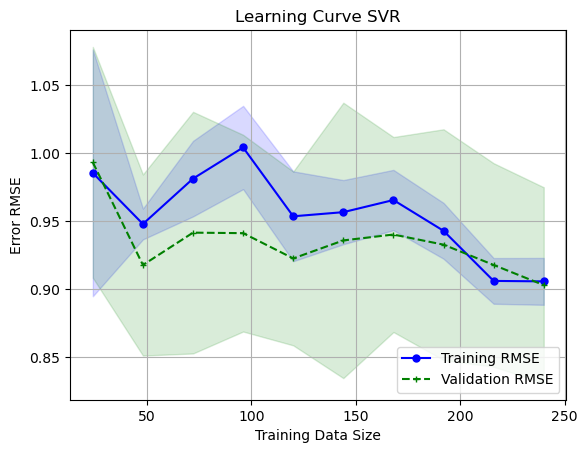

Error RSME(Test) de SVR: 0.916


In [ ]:
#Definiendo modelo, para optimizarlo
MLP_reg = MLPRegressor()

#Hiperparametros a optimizar
param_grid = {
    'hidden_layer_sizes': [(100,), (50, 50), (50, 25, 10),(150,100,50), (120,80,40), (100,50,30)],
    'max_iter': [50, 100],
    'activation': ['tanh', 'relu'],
    'alpha': 10.0 ** -np.arange(1, 7),
    'learning_rate': ['constant','adaptive'],
}

#Buscando los mejores hiperparámetros
MLP_opt = RandomizedSearchCV(estimator = MLP_reg, 
                               param_distributions = param_grid, 
                               n_iter = 100, 
                               cv = 5, 
                               verbose=2, 
                               random_state=42, 
                               n_jobs = -1)
MLP_opt.fit(XtrainT, np.ravel(ytrainlog))

elmodelo = MLPRegressor(**MLP_opt.best_params_)


mipipe = Pipeline(steps=[('ct',columnasTransformer),('m', elmodelo)])

train_sizes, train_scores, val_scores = learning_curve(estimator=mipipe,
                                                        X=XtrainT,
                                                        y=np.ravel(ytrainlog),
                                                        cv=5,
                                                        train_sizes= np.linspace(0.1, 1.0, 10),
                                                        scoring= 'neg_mean_squared_error',  # error MSE
                                                        n_jobs=-1)



# Calculamos los promedios y desviación estándar de entrenamiento para RMSE,
# como tenemos los de MSE, debemos obtener su raíz cuadrada. El negativo es porque
# sklearn nos devuelve en realidad el negativo del Error Cuadrático Medio MSE:

rmse_train_scores = np.sqrt(-train_scores)
rmse_val_scores = np.sqrt(-val_scores)

train_mean = np.mean(rmse_train_scores, axis=1)
train_std = np.std(rmse_train_scores, axis=1)
val_mean = np.mean(rmse_val_scores, axis=1)
val_std = np.std(rmse_val_scores, axis=1)


plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training RMSE')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, val_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation RMSE')
plt.fill_between(train_sizes, val_mean + val_std, val_mean - val_std, alpha=0.15, color='green')

plt.title('Learning Curve SVR')
plt.xlabel('Training Data Size')
plt.ylabel('Error RMSE')
plt.grid()
plt.legend(loc='lower right')
plt.show()

#Imprimiendo RMSE en conjunto de Prueba
mipipe = Pipeline(steps=[('ct',columnasTransformer),('m', elmodelo)])
mipipe.fit(Xtrain, np.ravel(ytrainlog))
yhattest_RF = mipipe.predict(Xtest)

print('Error RSME(Test) de SVR: %.3f' % np.sqrt(mean_squared_error(np.ravel(ytestlog), yhattest_RF)))